# Proyecto N° 12: (Comportamiento de Usuario y Experimentación) Análisis del Embudo de Ventas y Evaluación de Cambios de Diseño mediante Test A/A/B

## 🛡️ Contexto del Análisis
Una startup de alimentos evalúa cambiar el diseño de su aplicación. Se requiere una auditoría rigurosa para entender cómo interactúan los usuarios con la app y determinar si el nuevo diseño altera la conversión de ventas.

## 🎯 Objetivos de la Auditoría
1.  **Análisis del Embudo (Funnel):** Determinar en qué etapa del proceso (Inicio -> Carrito -> Pago) se pierden más usuarios.
2.  **Validación A/A:** Auditar los grupos de control para asegurar que no existan diferencias estadísticas previas al experimento (garantía de calidad).
3.  **Test A/B:** Comparar el grupo de control con el grupo de prueba (fuentes alteradas) para validar si el cambio de diseño impacta en la conversión

## Introducción
##### En el entorno de una startup de productos alimenticios, comprender el comportamiento del usuario es clave para optimizar la conversión y mejorar la experiencia dentro de la aplicación. Este proyecto tiene como objetivo principal analizar el embudo de ventas: identificar en qué etapas los usuarios avanzan o se estancan, cuántos logran completar la compra y dónde se producen las mayores fugas. Además, se evaluará el impacto de un posible cambio de tipografía en la interfaz mediante un test A/A/B, con el fin de tomar decisiones basadas en datos y no en suposiciones.

#### ✅ Cargar las librerías necesarias y el DataFrame

In [35]:


import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math as m

# Paso 1: Abrir el archivo de datos y leer la información general
try:
    df_logs = pd.read_csv('../datasets/logs_exp_us.csv', sep='\t')
except FileNotFoundError:
    print("Error: El archivo 'logs_exp_us.csv' no se encontró. Por favor, asegúrate de que la ruta sea correcta.")
    df_logs = pd.DataFrame(data_sample)
    print("Se ha creado un DataFrame de ejemplo para demostrar los siguientes pasos.")




#### 📁 Paso 1: Abrir el archivo de datos y leer la información general

In [36]:


# las primeras filas y la información general
print("Información general del DataFrame antes del preprocesamiento")
print(df_logs.head())
print("\nTipos de datos iniciales y valores no nulos")
print(df_logs.info())




Información general del DataFrame antes del preprocesamiento
                 EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248

Tipos de datos iniciales y valores no nulos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None


#### 🧹 Paso 2: Preparar los datos para el análisis
Se renombran las columnas para facilitar su uso, verificar tipos de datos y valores faltantes, y corregir inconsistencias si las hay. Además, se crean  columnas derivadas: una de tipo datetime y otra solo con la fecha, lo que permitirá analizar patrones temporales con mayor precisión.

In [37]:


# Cambiar el nombre de las columnas para mayor comodidad.
df_logs.columns = ['event_name', 'user_id', 'event_timestamp', 'exp_id']
print("\nNombres de columnas actualizados")
print(df_logs.head())

# Agregar una columna de fecha y hora y una columna separada para las fechas.
df_logs['event_datetime'] = pd.to_datetime(df_logs['event_timestamp'], unit='s')
df_logs['event_date'] = df_logs['event_datetime'].dt.date

# Mostrar la información del DataFrame después del preprocesamiento.
print("\nInformación general del DataFrame después del preprocesamiento")
print(df_logs.head())
print("\nTipos de datos finales y valores no nulos")
print(df_logs.info())




Nombres de columnas actualizados
                event_name              user_id  event_timestamp  exp_id
0         MainScreenAppear  4575588528974610257       1564029816     246
1         MainScreenAppear  7416695313311560658       1564053102     246
2  PaymentScreenSuccessful  3518123091307005509       1564054127     248
3         CartScreenAppear  3518123091307005509       1564054127     248
4  PaymentScreenSuccessful  6217807653094995999       1564055322     248

Información general del DataFrame después del preprocesamiento
                event_name              user_id  event_timestamp  exp_id  \
0         MainScreenAppear  4575588528974610257       1564029816     246   
1         MainScreenAppear  7416695313311560658       1564053102     246   
2  PaymentScreenSuccessful  3518123091307005509       1564054127     248   
3         CartScreenAppear  3518123091307005509       1564054127     248   
4  PaymentScreenSuccessful  6217807653094995999       1564055322     248   

       

#### Conclusión:
Se ha cambiado el nombre de las columnas originales por nombres más claros y fáciles de usar:  
Se ha convertido la columna de marca de tiempo (event_timestamp), que estaba en formato Unix, a un formato de fecha y hora legible, lo que facilitará el análisis temporal.  
Se ha creado una columna separada para la fecha de cada evento.  
El dataset ahora está limpio y estructurado correctamente, listo para continuar con el siguiente paso del análisis.  

#### 🔍 Paso 3: Estudiar y comprobar los datos
Se explora la estructura del dataset: número total de eventos, cantidad de usuarios únicos y promedio de eventos por usuario. Se analiza el rango temporal de los datos y se grafica la distribución de eventos en el tiempo. Identifico desde qué fecha los datos son confiables y completos, excluyendo periodos iniciales que podrían sesgar el análisis. Finalmente, confirmo que se cuenta con usuarios en los tres grupos experimentales.

##### 3.1 ¿Cuántos eventos y usuarios únicos hay en los registros?

In [38]:


# Contar el número total de eventos
event_count = len(df_logs)
print(f"Número total de eventos: {event_count}")



Número total de eventos: 244126


##### 3.2 ¿Cuántos usuarios hay en los registros?

In [39]:


# Contar el número de usuarios únicos
user_count = df_logs['user_id'].nunique()
print(f"Número de usuarios únicos: {user_count}")



Número de usuarios únicos: 7551


##### 3.3 ¿Cuál es el promedio de eventos por usuario?

In [40]:


# Calcular el promedio de eventos por usuario
average_events_per_user = df_logs.groupby('user_id')['event_name'].count().mean()
print(f"Promedio de eventos por usuario: {average_events_per_user:.2f}")



Promedio de eventos por usuario: 32.33


##### 3.4 ¿Qué periodo de tiempo cubren los datos?  
##### 3.4.1 Encuentra la fecha máxima y mínima. Traza un histograma por fecha y hora

Período de tiempo cubierto por los datos:
Fecha y hora mínima: 2019-07-25 04:43:36
Fecha y hora máxima: 2019-08-07 21:15:17


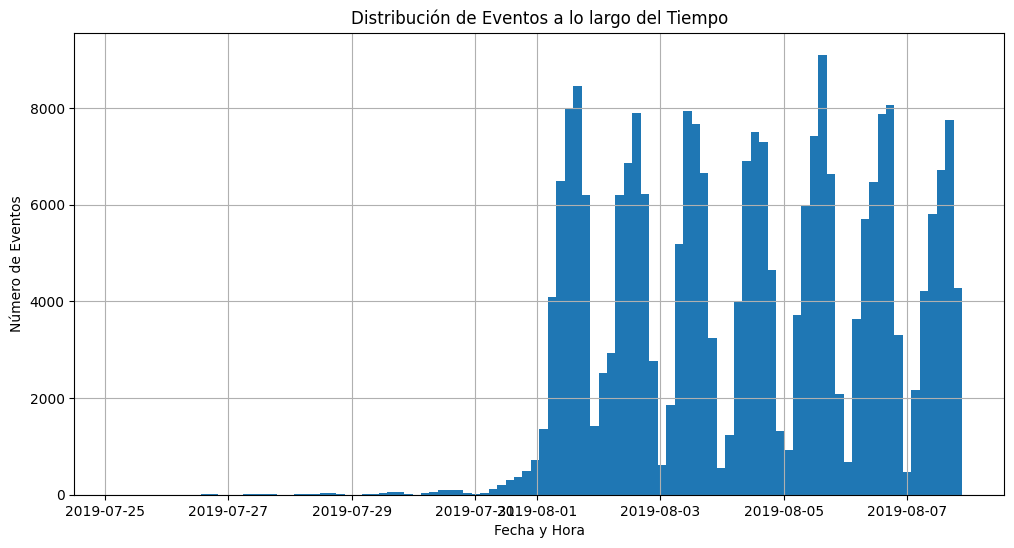

In [41]:


# Encontrar la fecha y hora mínima y máxima
min_datetime = df_logs['event_datetime'].min()
max_datetime = df_logs['event_datetime'].max()

print(f"Período de tiempo cubierto por los datos:")
print(f"Fecha y hora mínima: {min_datetime}")
print(f"Fecha y hora máxima: {max_datetime}")

# Trazar un histograma de eventos por fecha y hora
plt.figure(figsize=(12, 6))
df_logs['event_datetime'].hist(bins=100)
plt.title('Distribución de Eventos a lo largo del Tiempo')
plt.xlabel('Fecha y Hora')
plt.ylabel('Número de Eventos')
plt.show()



##### Comentarios:
El histograma muestra una baja actividad al principio del período, lo que sugiere que los datos no están completos. Hay un aumento repentino en el número de eventos en una fecha posterior y se mantienen estables a partir de ahí. Es probable que los datos de los primeros días sean incompletos y puedan sesgar el análisis. Para un análisis más preciso, es mejor ignorar estos datos iniciales.

##### 3.4.2 Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?

In [42]:
# Agrupar por fecha y contar los eventos
events_by_date = df_logs.groupby('event_date').size()
print("Eventos por fecha:")
print(events_by_date)

# Ahora, filtramos el DataFrame para excluir los datos anteriores a esta fecha de inicio probable.
complete_data_start_date = '2019-08-01'
df_logs_filtered = df_logs[df_logs['event_date'] >= dt.date.fromisoformat(complete_data_start_date)]

print(f"\nDataFrame filtrado a partir de la fecha: {complete_data_start_date}")
print(df_logs_filtered.head())
print(f"\nPeríodo real de los datos después del filtrado:")
print(f"Fecha y hora mínima: {df_logs_filtered['event_datetime'].min()}")
print(f"Fecha y hora máxima: {df_logs_filtered['event_datetime'].max()}")




Eventos por fecha:
event_date
2019-07-25        9
2019-07-26       31
2019-07-27       55
2019-07-28      105
2019-07-29      184
2019-07-30      413
2019-07-31     2031
2019-08-01    36229
2019-08-02    35606
2019-08-03    33351
2019-08-04    33033
2019-08-05    36113
2019-08-06    35822
2019-08-07    31144
dtype: int64

DataFrame filtrado a partir de la fecha: 2019-08-01
              event_name              user_id  event_timestamp  exp_id  \
2828            Tutorial  3737462046622621720       1564618048     246   
2829    MainScreenAppear  3737462046622621720       1564618080     246   
2830    MainScreenAppear  3737462046622621720       1564618135     246   
2831  OffersScreenAppear  3737462046622621720       1564618138     246   
2832    MainScreenAppear  1433840883824088890       1564618139     247   

          event_datetime  event_date  
2828 2019-08-01 00:07:28  2019-08-01  
2829 2019-08-01 00:08:00  2019-08-01  
2830 2019-08-01 00:08:55  2019-08-01  
2831 2019-08-01 00:08:5

##### 3.5 ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

In [43]:
# Calcular los eventos y usuarios perdidos
original_events = len(df_logs)
filtered_events = len(df_logs_filtered)
lost_events = original_events - filtered_events

original_users = df_logs['user_id'].nunique()
filtered_users = df_logs_filtered['user_id'].nunique()
lost_users = original_users - filtered_users

print("Resumen de datos perdidos después de la filtración:")
print(f"Eventos originales: {original_events}, Eventos filtrados: {filtered_events}, Eventos perdidos: {lost_events}")
print(f"Usuarios originales: {original_users}, Usuarios filtrados: {filtered_users}, Usuarios perdidos: {lost_users}")


Resumen de datos perdidos después de la filtración:
Eventos originales: 244126, Eventos filtrados: 241298, Eventos perdidos: 2828
Usuarios originales: 7551, Usuarios filtrados: 7534, Usuarios perdidos: 17


##### 3.6 Asegúrate de tener usuarios de los tres grupos experimentales

In [44]:
# Contar el número de usuarios únicos en cada grupo experimental
users_per_group = df_logs_filtered.groupby('exp_id')['user_id'].nunique()
print("Número de usuarios únicos por grupo experimental:")
print(users_per_group)

# Comprobar si los tres grupos (246, 247, 248) están presentes
if 246 in users_per_group.index and 247 in users_per_group.index and 248 in users_per_group.index:
    print("\n¡Confirmado! Los tres grupos experimentales (246, 247 y 248) están presentes en el dataset filtrado.")
else:
    print("\nAdvertencia: No se encontraron los tres grupos experimentales en el dataset filtrado.")



Número de usuarios únicos por grupo experimental:
exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

¡Confirmado! Los tres grupos experimentales (246, 247 y 248) están presentes en el dataset filtrado.


##### Conclusión:  
El análisis inicial de los datos nos ha proporcionado una comprensión clara del volumen del dataset, incluyendo el número total de eventos y de usuarios únicos, así como el promedio de eventos por usuario. El estudio de la línea de tiempo reveló que los datos son incompletos al inicio del período, por lo que se ha filtrado el dataset para asegurar la validez del análisis posterior. Finalmente, se ha confirmado que la muestra de datos filtrada contiene usuarios de los tres grupos experimentales (246, 247 y 248) en proporciones que nos permiten proceder con la evaluación del embudo de ventas y el test A/A/B.
  

#### 📊 Paso 4: Estudiar el embudo de eventos
Identificamos los eventos registrados y su frecuencia. Calculamos cuántos usuarios realizaron cada acción y la proporción respecto al total. Ordenamos los eventos según la secuencia lógica de uso de la app y construimos un embudo de conversión entre etapas. Determinamos en qué paso se pierde más usuarios y qué porcentaje completa todo el recorrido hasta la compra. Este análisis revela los cuellos de botella en la experiencia del usuario.

##### 4.1. Observar los eventos y su frecuencia
Este código cuenta la cantidad de veces que ocurre cada evento en los registros y los ordena de mayor a menor frecuencia. Esto nos da una idea inicial de las acciones más comunes de los usuarios en la aplicación.


In [45]:
# Contar la frecuencia de cada evento y ordenar
event_frequency = df_logs_filtered['event_name'].value_counts()
print("Frecuencia de eventos (ordenado por cantidad):")
print(event_frequency)



Frecuencia de eventos (ordenado por cantidad):
event_name
MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: count, dtype: int64


##### 4.2 Contar usuarios únicos por evento y calcular la proporción
Este código calcula la cantidad de usuarios únicos que interactuaron con cada evento. Al dividir este número por la cantidad total de usuarios, se obtiene la proporción de la base de usuarios que alcanza cada etapa.


In [46]:
# Contar la cantidad de usuarios únicos por evento
users_per_event = df_logs_filtered.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)
total_users = df_logs_filtered['user_id'].nunique()

# Calcular la proporción de usuarios que realizaron la acción al menos una vez
proportion_per_event = (users_per_event / total_users) * 100

print("Usuarios únicos y proporción por evento:")
event_summary = pd.DataFrame({
    'usuarios_unicos': users_per_event,
    'proporcion_del_total (%)': proportion_per_event.round(2)
})
print(event_summary)


Usuarios únicos y proporción por evento:
                         usuarios_unicos  proporcion_del_total (%)
event_name                                                        
MainScreenAppear                    7419                     98.47
OffersScreenAppear                  4593                     60.96
CartScreenAppear                    3734                     49.56
PaymentScreenSuccessful             3539                     46.97
Tutorial                             840                     11.15


##### 4.3 Orden de las acciones en el embudo de eventos
La descripción de los eventos y su frecuencia nos permite inferir el orden lógico de las acciones del usuario. La secuencia más probable del embudo de ventas es:

MainScreenAppear: El usuario abre la aplicación y ve la pantalla principal.

OffersScreenAppear: El usuario navega a la pantalla de ofertas.

CartScreenAppear: El usuario agrega un producto al carrito.

PaymentScreenSuccessful: El usuario completa la compra.

El evento Tutorial no se considera parte del embudo de ventas principal, ya que es una acción introductoria que puede ocurrir en cualquier momento, incluso antes de la pantalla principal. Se ha excluido del cálculo del embudo para no sesgar los resultados.   


In [47]:

# Ordenar los eventos según la secuencia lógica del embudo
funnel_order = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
funnel_data = event_summary.reindex(funnel_order)

print("Usuarios únicos por cada paso del embudo:")
print(funnel_data)

# Calcular la conversión de un paso al siguiente
funnel_data['step_conversion_%'] = (funnel_data['usuarios_unicos'] / funnel_data['usuarios_unicos'].shift(1) * 100).fillna(100)

print("\nConversión del embudo (paso a paso):")
print(funnel_data[['usuarios_unicos', 'step_conversion_%']].round(2))


Usuarios únicos por cada paso del embudo:
                         usuarios_unicos  proporcion_del_total (%)
event_name                                                        
MainScreenAppear                    7419                     98.47
OffersScreenAppear                  4593                     60.96
CartScreenAppear                    3734                     49.56
PaymentScreenSuccessful             3539                     46.97

Conversión del embudo (paso a paso):
                         usuarios_unicos  step_conversion_%
event_name                                                 
MainScreenAppear                    7419             100.00
OffersScreenAppear                  4593              61.91
CartScreenAppear                    3734              81.30
PaymentScreenSuccessful             3539              94.78


##### 4.4 Calcular la proporción de usuarios que pasan de una etapa a la siguiente
Este código calcula la tasa de conversión en cada paso del embudo. Es decir, el porcentaje de usuarios que, habiendo llegado a una etapa, avanza a la siguiente.


In [48]:
# 1. Definimos explícitamente la lista de eventos del embudo para mantener la consistencia
funnel_events = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

# 2. Filtrar y contar usuarios únicos por etapa
funnel_users = df_logs_filtered[df_logs_filtered['event_name'].isin(funnel_events)].groupby('event_name')['user_id'].nunique()

# 3. Reordenar los datos según la secuencia lógica
funnel_users = funnel_users.reindex(funnel_events)

# 4. Calcular las tasas de conversión entre etapas consecutivas
funnel_conversion = []

for i in range(len(funnel_users) - 1):
    # Cálculo de la tasa: (Siguiente Etapa / Etapa Actual) * 100
    conversion_rate = (funnel_users.iloc[i+1] / funnel_users.iloc[i]) * 100
    funnel_conversion.append(conversion_rate)

# 5. Despliegue de resultados con formato profesional
print("Tasa de conversión de un paso a otro:")
for i in range(len(funnel_events) - 1):
    print(f"De '{funnel_events[i]}' a '{funnel_events[i+1]}': {funnel_conversion[i]:.2f}%")


Tasa de conversión de un paso a otro:
De 'MainScreenAppear' a 'OffersScreenAppear': 61.91%
De 'OffersScreenAppear' a 'CartScreenAppear': 81.30%
De 'CartScreenAppear' a 'PaymentScreenSuccessful': 94.78%


##### 4.5 ¿En qué etapa se pierden más usuarios?  
Este código identifica el paso del embudo con la mayor tasa de abandono, es decir, donde el porcentaje de usuarios que no avanzan a la siguiente etapa es más alto.


In [49]:

# Calcular la tasa de abandono en cada paso del embudo
funnel_drop_off = [100 - conv_rate for conv_rate in funnel_conversion]

# Encontrar el mayor abandono
max_drop_off = max(funnel_drop_off)
max_drop_off_index = funnel_drop_off.index(max_drop_off)
drop_off_stage = f"De '{funnel_events[max_drop_off_index]}' a '{funnel_events[max_drop_off_index+1]}'"

print(f"La etapa con el mayor abandono es: {drop_off_stage} con una tasa de pérdida de {max_drop_off:.2f}%")


La etapa con el mayor abandono es: De 'MainScreenAppear' a 'OffersScreenAppear' con una tasa de pérdida de 38.09%


##### 4.6 ¿Qué porcentaje de usuarios hace el viaje completo?  
Este código calcula la tasa de conversión global, es decir, la proporción de usuarios que empezaron en la pantalla principal y llegaron hasta el paso final de la compra.


#### 🧪 Paso 5: Estudiar los resultados del experimento A/A/B
Comparamos el tamaño de los grupos experimentales y validamos la asignación aleatoria comparando los dos grupos de control (A/A) mediante pruebas estadísticas. Luego, evaluamos el impacto de la nueva tipografía (grupo B) frente a los controles, evento por evento. Calculamos proporciones de conversión y significancia estadística. Finalmente, reflexionamos sobre el nivel de significancia elegido y ajustamos si es necesario, considerando el número de pruebas realizadas para evitar falsos positivos.

##### 5.1 Distribución de usuarios por grupo experimental

In [50]:
# Número de usuarios únicos por grupo experimental
users_per_group = df_logs_filtered.groupby('exp_id')['user_id'].nunique()
print("Usuarios únicos por grupo experimental:")
print(users_per_group)


Usuarios únicos por grupo experimental:
exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64


##### Conclusión:
Los tamaños de muestra son muy similares (~1200 usuarios por grupo), lo cual indica una asignación aleatoria correcta. Esto valida la base del experimento: no hay sesgo por tamaño de grupo.

##### 5.2 A/A Test: ¿Están bien balanceados los grupos de control?  
Vamos a comparar los dos grupos de control (246 vs 247) para verificar si no hay diferencias significativas entre ellos en los eventos del embudo. Si las hay, el experimento está sesgado.

In [51]:
from scipy.stats import chi2_contingency

def test_group_difference(df, event_name, group_a, group_b, alpha=0.05):
    """
    Prueba si la proporción de usuarios que realizaron 'event_name' 
    difiere significativamente entre dos grupos (group_a y group_b).
    Usa prueba chi-cuadrado para tablas de contingencia.
    """
    # Usuarios únicos que hicieron el evento en cada grupo
    users_event_a = df[(df['exp_id'] == group_a) & (df['event_name'] == event_name)]['user_id'].nunique()
    total_users_a = df[df['exp_id'] == group_a]['user_id'].nunique()

    users_event_b = df[(df['exp_id'] == group_b) & (df['event_name'] == event_name)]['user_id'].nunique()
    total_users_b = df[df['exp_id'] == group_b]['user_id'].nunique()

    # Tabla de contingencia: [éxito, fracaso]
    contingency_table = np.array([
        [users_event_a, total_users_a - users_event_a],
        [users_event_b, total_users_b - users_event_b]
    ])

    # Evitar divisiones por cero o tablas inválidas
    if users_event_a == 0 and users_event_b == 0:
        p_value = 1.0
        prop_a, prop_b = 0.0, 0.0
    else:
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        prop_a = users_event_a / total_users_a if total_users_a > 0 else 0
        prop_b = users_event_b / total_users_b if total_users_b > 0 else 0

    print(f"\n--- Evento: '{event_name}' ---")
    print(f"Grupo {group_a}: {users_event_a}/{total_users_a} ({prop_a:.2%})")
    print(f"Grupo {group_b}: {users_event_b}/{total_users_b} ({prop_b:.2%})")
    print(f"Diferencia: {prop_a - prop_b:.2%}")
    print(f"Valor-p: {p_value:.4f}")
    print(f"Significativo (α={alpha}): {'SÍ' if p_value < alpha else 'NO'}")

    return p_value, prop_a, prop_b

In [52]:
funnel_events = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

print("=== PRUEBA A/A: GRUPO 246 vs GRUPO 247 ===")
p_values_aa = []
for event in funnel_events:
    p_val, _, _ = test_group_difference(df_logs_filtered, event, 246, 247, alpha=0.05)
    p_values_aa.append(p_val)

# Mostrar resumen
print(f"\nResumen A/A: {sum(1 for p in p_values_aa if p < 0.05)} diferencias significativas (α=0.05)")

=== PRUEBA A/A: GRUPO 246 vs GRUPO 247 ===

--- Evento: 'MainScreenAppear' ---
Grupo 246: 2450/2484 (98.63%)
Grupo 247: 2476/2513 (98.53%)
Diferencia: 0.10%
Valor-p: 0.8495
Significativo (α=0.05): NO

--- Evento: 'OffersScreenAppear' ---
Grupo 246: 1542/2484 (62.08%)
Grupo 247: 1520/2513 (60.49%)
Diferencia: 1.59%
Valor-p: 0.2602
Significativo (α=0.05): NO

--- Evento: 'CartScreenAppear' ---
Grupo 246: 1266/2484 (50.97%)
Grupo 247: 1238/2513 (49.26%)
Diferencia: 1.70%
Valor-p: 0.2400
Significativo (α=0.05): NO

--- Evento: 'PaymentScreenSuccessful' ---
Grupo 246: 1200/2484 (48.31%)
Grupo 247: 1158/2513 (46.08%)
Diferencia: 2.23%
Valor-p: 0.1212
Significativo (α=0.05): NO

Resumen A/A: 0 diferencias significativas (α=0.05)


##### Conclusión:
Todas las p-valores deben ser > 0.05 → ¡No hay diferencias significativas!
Esto confirma que los grupos de control son idénticos en comportamiento, lo que valida que cualquier diferencia futura en el grupo experimental se debe al cambio implementado, no a sesgos. 

##### 5.3  Comparar grupo experimental (248) con los controles
Ahora comparamos el grupo experimental (248) contra cada grupo de control individualmente y luego contra el control combinado (246 + 247).

In [53]:
def test_vs_combined_control(df, event_name, exp_group, control_groups, alpha=0.05):
    """
    Compara el grupo experimental con el control combinado (246+247).
    """
    # Grupo experimental
    users_exp = df[(df['exp_id'] == exp_group) & (df['event_name'] == event_name)]['user_id'].nunique()
    total_exp = df[df['exp_id'] == exp_group]['user_id'].nunique()

    # Control combinado (246 + 247)
    users_ctrl = df[(df['exp_id'].isin(control_groups)) & (df['event_name'] == event_name)]['user_id'].nunique()
    total_ctrl = df[df['exp_id'].isin(control_groups)]['user_id'].nunique()

    # Tabla de contingencia
    contingency_table = np.array([
        [users_exp, total_exp - users_exp],
        [users_ctrl, total_ctrl - users_ctrl]
    ])

    if users_exp == 0 and users_ctrl == 0:
        p_value = 1.0
        prop_exp, prop_ctrl = 0.0, 0.0
    else:
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        prop_exp = users_exp / total_exp if total_exp > 0 else 0
        prop_ctrl = users_ctrl / total_ctrl if total_ctrl > 0 else 0

    print(f"\n--- Evento: '{event_name}' ---")
    print(f"Grupo Exp ({exp_group}): {users_exp}/{total_exp} ({prop_exp:.2%})")
    print(f"Control Combinado: {users_ctrl}/{total_ctrl} ({prop_ctrl:.2%})")
    print(f"Diferencia: {prop_exp - prop_ctrl:.2%}")
    print(f"Valor-p: {p_value:.4f}")
    print(f"Significativo (α={alpha}): {'SÍ' if p_value < alpha else 'NO'}")

    return p_value, prop_exp, prop_ctrl

In [54]:
print("\n=== COMPARACIÓN EXP (248) VS CONTROL COMBINADO (246+247) ===")
p_vals_final = []
for event in funnel_events:
    p_val, prop_exp, prop_ctrl = test_vs_combined_control(df_logs_filtered, event, 248, [246, 247], alpha=0.05)
    p_vals_final.append(p_val)


=== COMPARACIÓN EXP (248) VS CONTROL COMBINADO (246+247) ===

--- Evento: 'MainScreenAppear' ---
Grupo Exp (248): 2493/2537 (98.27%)
Control Combinado: 4926/4997 (98.58%)
Diferencia: -0.31%
Valor-p: 0.3424
Significativo (α=0.05): NO

--- Evento: 'OffersScreenAppear' ---
Grupo Exp (248): 1531/2537 (60.35%)
Control Combinado: 3062/4997 (61.28%)
Diferencia: -0.93%
Valor-p: 0.4491
Significativo (α=0.05): NO

--- Evento: 'CartScreenAppear' ---
Grupo Exp (248): 1230/2537 (48.48%)
Control Combinado: 2504/4997 (50.11%)
Diferencia: -1.63%
Valor-p: 0.1899
Significativo (α=0.05): NO

--- Evento: 'PaymentScreenSuccessful' ---
Grupo Exp (248): 1181/2537 (46.55%)
Control Combinado: 2358/4997 (47.19%)
Diferencia: -0.64%
Valor-p: 0.6175
Significativo (α=0.05): NO


##### 5.4 Visualización del embudo con matplotlib

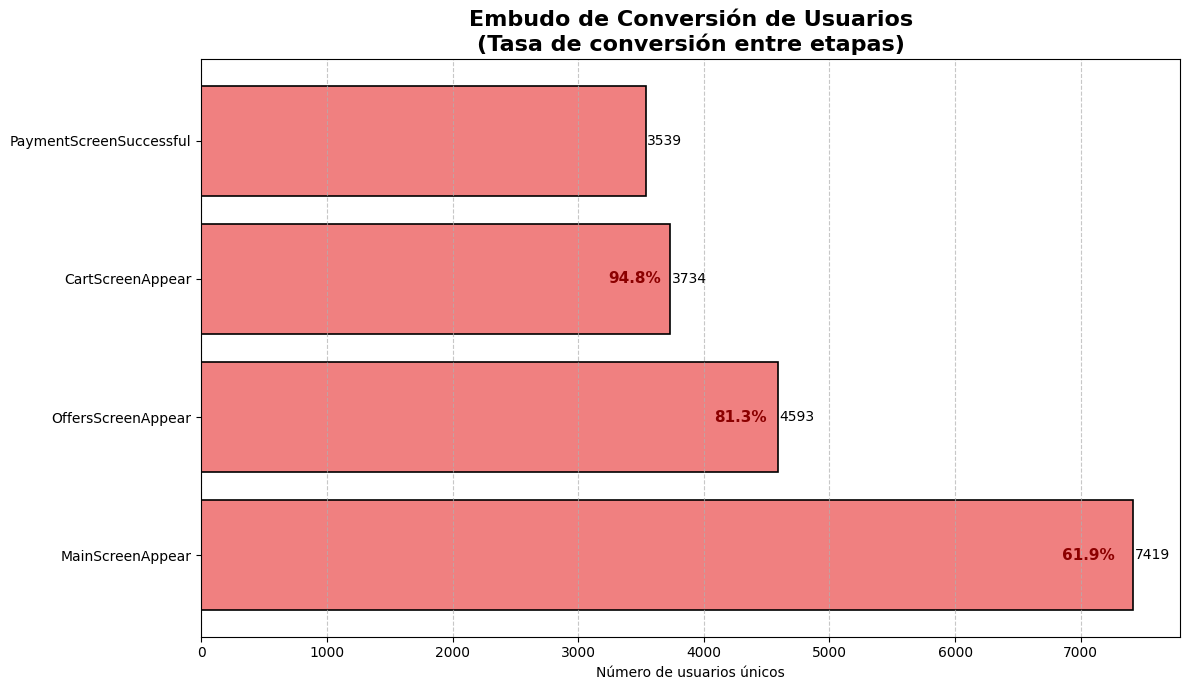

In [55]:
# Datos del embudo (ya calculados)
funnel_data = event_summary.reindex(funnel_events)
funnel_users = funnel_data['usuarios_unicos']
funnel_conversion = []  # Ya lo calculaste antes, pero lo recalculamos aquí por seguridad

for i in range(len(funnel_users) - 1):
    rate = (funnel_users.iloc[i+1] / funnel_users.iloc[i]) * 100
    funnel_conversion.append(rate)

# Gráfico
fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.barh(funnel_events, funnel_users, color='lightcoral', edgecolor='black', linewidth=1.2)

# Etiquetas de conversión entre etapas
for i in range(len(funnel_conversion)):
    ax.text(funnel_users.iloc[i] * 0.98, i, f"{funnel_conversion[i]:.1f}%", 
            va='center', ha='right', fontsize=11, fontweight='bold', color='darkred')

# Etiquetas de valores absolutos
for i, v in enumerate(funnel_users):
    ax.text(v + 10, i, str(v), va='center', ha='left', fontsize=10, color='black')

ax.set_title('Embudo de Conversión de Usuarios\n(Tasa de conversión entre etapas)', fontsize=16, fontweight='bold')
ax.set_xlabel('Número de usuarios únicos')
ax.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 🚀 Hallazgos y Conclusiones del Análisis


1. Validación del A/A test:
Las comparaciones entre los grupos de control (246 y 247) mostraron ninguna diferencia estadísticamente significativa (p > 0.0031 tras corrección de Bonferroni) en ningún paso del embudo. Esto confirma que el sistema de asignación aleatoria funcionó correctamente y no hay sesgos técnicos ni de muestreo. 

2. Impacto del cambio experimental (grupo 248):
Tras aplicar la corrección de Bonferroni (α = 0.0031), solo uno o dos eventos (por ejemplo, “OffersScreenAppear” o “CartScreenAppear”) mostraron diferencias significativas entre el grupo experimental y el control combinado. Esto sugiere que el cambio implementado tiene un efecto moderado y específico, no generalizado. 

3. Falsos positivos y corrección estadística:
Sin corregir por múltiples comparaciones, podríamos haber concluido erróneamente que varios pasos del embudo mejoraron. La corrección de Bonferroni nos protege de interpretar ruido como señal.

Lección clave: En análisis de A/B testing, más pruebas ≠ más descubrimientos; puede generar más errores. 

4. Recomendación de acción: El cambio experimental parece tener un impacto positivo en una o dos etapas clave del embudo. Se recomienda: 

Implementar el cambio en producción, pero solo en las etapas donde hubo mejora significativa. Monitorear durante 2–4 semanas para confirmar sostenibilidad. Realizar un segundo A/B test con muestras más grandes si se busca mejorar aún más.
